In [100]:
import pandas as pd
from pymongo import MongoClient

In [101]:
def _connect_mongo(host, port, username, password, db):
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return conn[db]

In [102]:
def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    cursor = db[collection].find(query)
    df =  pd.DataFrame(list(cursor))
    if no_id:
        del df['_id']
    return df

In [103]:
df=read_mongo('Spotify', 'Api_data')  
df

,,Artist Name,Genres,Popularity,Followers Count
0,0,Dakpa Nepali,singing bowl,38,1404
1,1,Swoopna Suman,nepali pop,46,193318
2,2,Sajjan Raj Vaidya,nepali pop,53,504272
3,3,Trishna Gurung,nepali pop,39,61402
4,4,Melina Rai,nepali pop,43,61665
...,...,...,...,...,...
495,495,Arjun Kaushal,cover artist,9,111
496,496,Sashan Kandel,cover artist,5,142
497,497,Nirmala Bhandari,cover artist,8,41
498,498,Uday Raj Poudel,nepali indie,5,90


In [104]:
df.columns

Index(['', 'Artist Name', 'Genres', 'Popularity', 'Followers Count'], dtype='object')

In [105]:
df['Genres'].value_counts()

cover artist         221
nepali pop           204
lok dohori            17
rap                   14
nepali indie          13
modern classical       8
nepali rock            8
himalayan folk         6
music distributor      5
folk rock              2
singing bowl           1
hard rock              1
Name: Genres, dtype: int64

In [106]:
df['genres_type']=df['Genres'].replace({'cover artist':1,'nepali pop':2,'lok dohori':3,'rap':4,'nepali indie':5,          
'modern classical':6,'nepali rock':7,'himalayan folk':8,'music distributor':9,'folk rock':10,'singing bowl':11,
'hard rock':12})
df.head()


,,Artist Name,Genres,Popularity,Followers Count,genres_type
0,0,Dakpa Nepali,singing bowl,38,1404,11
1,1,Swoopna Suman,nepali pop,46,193318,2
2,2,Sajjan Raj Vaidya,nepali pop,53,504272,2
3,3,Trishna Gurung,nepali pop,39,61402,2
4,4,Melina Rai,nepali pop,43,61665,2


In [107]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot: xlabel='Followers Count', ylabel='Genres'>

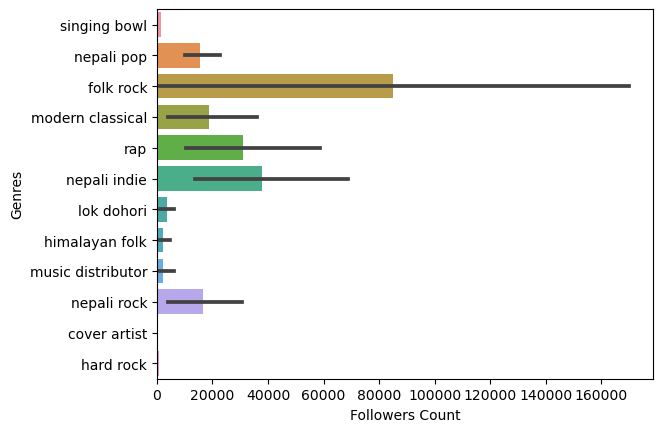

In [108]:
sns.barplot(y='Genres',x='Followers Count',data=df)

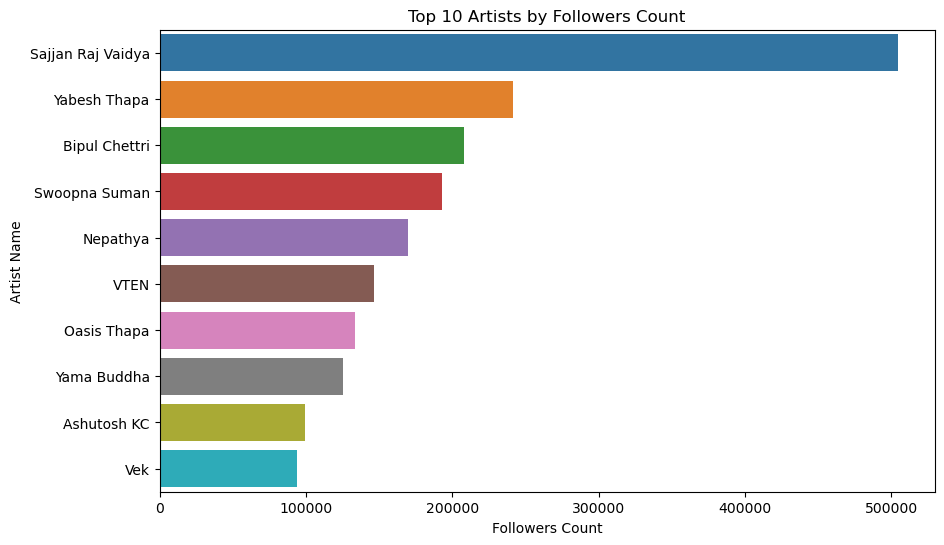

In [109]:
top_10_artists = df.sort_values(by='Followers Count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y='Artist Name', x='Followers Count', data=top_10_artists)
plt.title('Top 10 Artists by Followers Count')
plt.xlabel('Followers Count')
plt.ylabel('Artist Name')
plt.show()

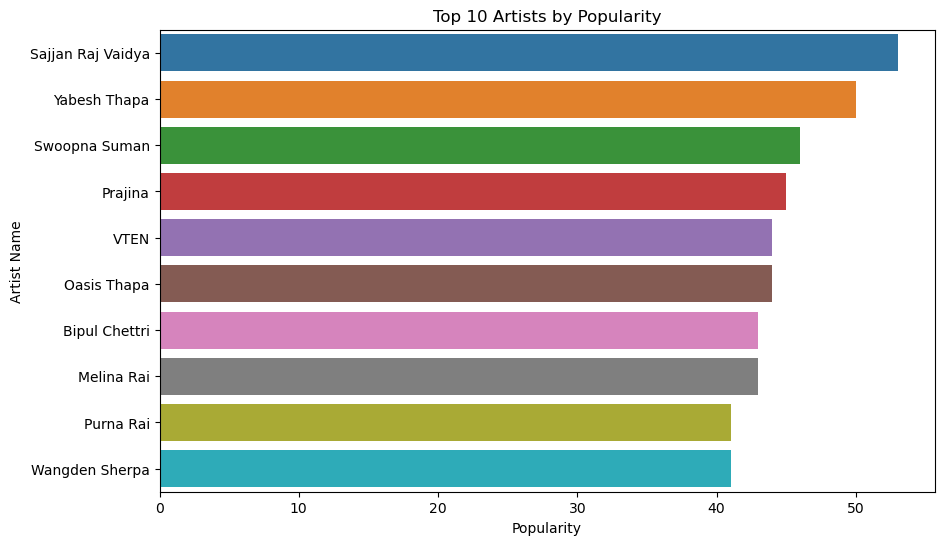

In [110]:
top_10_artists = df.sort_values(by='Popularity', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y='Artist Name', x='Popularity', data=top_10_artists)
plt.title('Top 10 Artists by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Artist Name')
plt.show()

In [111]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [112]:
x=df[['Followers Count','Popularity']]
y=df['genres_type']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model=KNeighborsClassifier()
model.fit(X_train,y_train)

KNeighborsClassifier()

In [114]:
X_train.shape

(400, 2)

In [115]:
y_train.shape

(400,)

In [116]:
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
classification_report=classification_report(y_test,y_pred)
print("Accuracy:",accuracy)
print("Classification report:",classification_report)

Accuracy: 0.63
Classification report:               precision    recall  f1-score   support

           1       0.68      0.78      0.73        46
           2       0.57      0.69      0.63        39
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1

    accuracy                           0.63       100
   macro avg       0.14      0.16      0.15       100
weighted avg       0.54      0.63      0.58       100



In [117]:
sample=[[24000,98]]
y_pred=model.predict(sample)
print("The genre is",y_pred)

The genre is [2]


In [118]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_similar_artists(artist_name, df, top_n=4):
    # Retrieve information of the input artist
    input_artist_info = df[df['Artist Name'] == artist_name]
    input_genre = input_artist_info['genres_type'].values[0]
    
    # Select relevant feature (genre type)
    features = df['genres_type'].values
    
    # Reshape input_genre and features to have compatible shapes for cosine similarity calculation
    input_genre = input_genre.reshape(1, -1)
    features = features.reshape(len(features), -1)
    
    # Calculate similarity between input artist and all other artists based on genre type
    similarity_scores_genre = cosine_similarity(input_genre, features)
    
    # Find indices of top similar artists
    similar_artists_indices = np.argsort(similarity_scores_genre[0])[::-1][:top_n]  # Exclude the input artist itself
    
    # Recommend top-N similar artists
    similar_artists = df.iloc[similar_artists_indices]
    
    return similar_artists

# Example usage:
artist_name = input("Enter the artist name: ")
similar_artists = recommend_similar_artists(artist_name, df)
print("Similar Artists based on Genre Match:")
print(similar_artists[['Artist Name', 'genres_type']])


Similar Artists based on Genre Match:
     Artist Name  genres_type
499    Dr Pilots            1
170  Dibya Subba            2
157     Natikaji            2
158      Hrittal            1
